In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt
import gc
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score

import plotly.express as px
import TsModel
import GprModel
from sklearn.utils import validation
from windrose import WindroseAxes
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.path import Path
from matplotlib.transforms import Affine2D
from matplotlib.patches import Circle, RegularPolygon

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Visualization for all models, used in the paper

In [3]:
plt.rcParams.update({'font.size': 18})

In [13]:
# Modified from source: https://blog.paperspace.com/svr-kmeans-clustering-for-regression/#implementing-k-means-clustering-svr
def kmeans_model(X_train, Y_train, n_clusters=30):
    
    kmeans = KMeans(
    init="random",
    n_clusters=n_clusters,
    max_iter=300)
    
    # Fit to the training data
    kmeans.fit(X_train)
    # Generate out clusters
    train_cluster = kmeans.predict(X_train)
    
    cluster_predictors = []

    for i in range(n_clusters):
        index = np.where(train_cluster == i)[0]
        cluster_X = X_train[index]
        cluster_Y = Y_train[index]
        model = LinearRegression()
        cluster_predictors.append(model.fit(cluster_X, cluster_Y))
    
    return kmeans, cluster_predictors

def regression_function(X_test, kmeans, cluster_svr):
    result = []
    clusters_pred = kmeans.predict(X_test)
    for i,data in enumerate(X_test):
        result.append(((cluster_svr[clusters_pred[i]]).predict([data]))[0])
    return result,clusters_pred

In [14]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [15]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [1,2,3,4,5,6,7,8,9, 10,11,12]

# Expeirment related parameters
number_of_folds = 10 # have to be 10 fold

# Results containers
training_results = []
test_results = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):    
    for hyperparameter_value in hyper_parameter_to_test_values:
        # Station data is generated already, only need to train the model
        flatten_train_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}x.csv", index_col=0).to_numpy()
        flatten_train_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}y.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

        # Test data should still need to be generated
        flatten_test_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}x_test.csv", index_col=0).to_numpy()
        flatten_test_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}y_test.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        test_results_fold = []
            
        for i in range(0, number_of_folds):
            flatten_train_x, flatten_train_y = shuffle(flatten_train_x, flatten_train_y)
    
            flatten_train_x = np.asarray(flatten_train_x).astype('float32')
            flatten_train_y = np.asarray(flatten_train_y).astype('float32')
            flatten_test_x = np.asarray(flatten_test_x).astype('float32')
            flatten_test_y = np.asarray(flatten_test_y).astype('float32')
            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")

            # Normalize the input
            norm_flatten_train_x, norm_flatten_test_x = preprocess_data(flatten_train_x, flatten_test_x)            
            
            # Kmeans
            kmeans, k_means_models = kmeans_model(norm_flatten_train_x, flatten_train_y, n_clusters=30)
            result,clusters = regression_function(norm_flatten_train_x, kmeans, k_means_models)
            kmeans_train_rmse = mean_squared_error(result, flatten_train_y, squared=False)
            training_results_fold.append({'kmeans_train' : kmeans_train_rmse})
            
            result,clusters = regression_function(norm_flatten_test_x, kmeans, k_means_models)
            kmeans_test_rmse = mean_squared_error(result, flatten_test_y, squared=False)
            test_results_fold.append({'kmeans_test' : kmeans_test_rmse})
        
        #After all folds are done, update the result containers
        training_results.append(training_results_fold)
        test_results.append(test_results_fold)        

In [16]:
do_experiment(number_of_neighbour_stations)

Currently running fold 0 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [4]:
# training_results_li_ts_km_nn_full_feature = cleaned_training_results_full_feature
# test_results_li_ts_km_nn_full_feature = cleaned_test_results_full_feature

# %store training_results_li_ts_km_nn_full_feature
# %store test_results_li_ts_km_nn_full_feature

%store -r training_results_li_ts_km_nn_full_feature
%store -r test_results_li_ts_km_nn_full_feature

# %store -r training_results_kmeans
# %store -r test_results_kmeans


# %store -r  fcm_opt_training_results
# %store -r  fcm_opt_test_results

exp
linear
7.2311±0.0
nn
6.2463±0.0068
fcm
6.4227±0.0108
kmeans
6.460899829864502±0.021800000220537186
exp
linear
7.0071±0.0
nn
5.8777±0.0068
fcm
5.9567±0.011
kmeans
6.02839994430542±0.010400000028312206
exp
linear
6.9039±0.0
nn
5.6055±0.0053
fcm
5.6616±0.004
kmeans
5.747099876403809±0.009700000286102295
exp
linear
6.6041±0.0
nn
5.5082±0.0067
fcm
5.5659±0.0081
kmeans
5.675300121307373±0.008799999952316284
exp
linear
6.4277±0.0
nn
5.4781±0.0045
fcm
5.5066±0.0104
kmeans
5.616700172424316±0.01209999993443489
exp
linear
6.4203±0.0
nn
5.4465±0.0047
fcm
5.4596±0.0073
kmeans
5.617499828338623±0.019899999722838402
exp
linear
6.456±0.0
nn
5.4597±0.0055
fcm
5.4547±0.0116
kmeans
5.590700149536133±0.02239999920129776
exp
linear
6.5277±0.0
nn
5.446±0.0046
fcm
5.4054±0.004
kmeans
5.55810022354126±0.006599999964237213
exp
linear
6.452±0.0
nn
5.4436±0.0054
fcm
5.3981±0.0069
kmeans
5.555099964141846±0.013100000098347664
exp
linear
6.4835±0.0
nn
5.6134±0.4956
fcm
5.4098±0.0132
kmeans
5.5594000816345215±

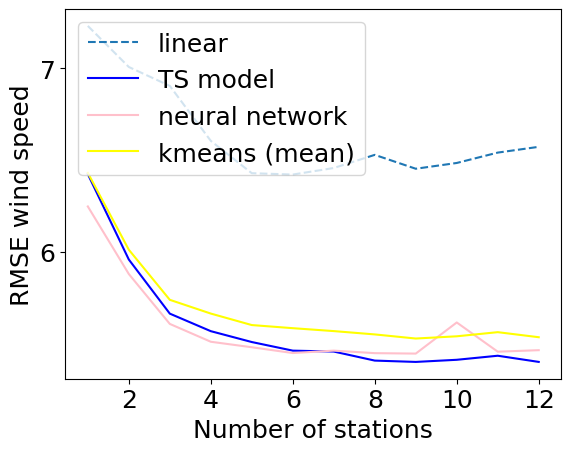

In [5]:
#RMSE wind speed vs number of stations on training data
kmeans_train_plot = []
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in training_results_li_ts_km_nn_full_feature:
     kmeans_train_plot.append(np.min([d['kmeans_train'] for d in exp if 'kmeans_train' in d]))
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, kmeans_train_plot, label='kmeans (mean)', c='yellow')
plt.legend(loc="upper left")
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')

for exp in training_results_li_ts_km_nn_full_feature:
    print('exp')
    print('linear')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    
    print('nn')
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")
 
    print('fcm')
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
 
    print('kmeans')
    print(f"{np.round(np.mean([d['kmeans_train'] for d in exp if 'kmeans_train' in d]), 4)}±{np.round(np.std([d['kmeans_train'] for d in exp if 'kmeans_train' in d]),4)}")
 

In [6]:
gpr_test_results=[]
gpr_test_results.append({'gpr_test': 124.28245462517742})
gpr_test_results.append({'gpr_test': 8.098453253845573})
gpr_test_results.append({'gpr_test': 7.383525517000387})
gpr_test_results.append({'gpr_test': 7.266723098591452})
gpr_test_results.append({'gpr_test': 7.269252212307546})
gpr_test_results.append({'gpr_test': 7.246991937014375})
gpr_test_results.append({'gpr_test': 7.127975366729728})
gpr_test_results.append({'gpr_test': 7.125519317911804})
gpr_test_results.append({'gpr_test': 7.096831995981307})
gpr_test_results.append({'gpr_test': 7.09245097390881})
gpr_test_results.append({'gpr_test': 7.123352723065476})
gpr_test_results.append({'gpr_test': 7.136209476848252})

In [11]:
for exp in test_results_li_ts_km_nn_full_feature:
    print('exp')
    print('kmeans min')
    print([d['kmeans_test'] for d in exp if 'kmeans_test' in d])

exp
kmeans min
[6.482081, 6.4570947, 6.4706683, 6.4742827, 6.499645, 6.5023813, 6.4517727, 6.471807, 6.470887, 6.5207343]
exp
kmeans min
[167.17743, 6.0413256, 6.0166483, 6.04587, 6.043872, 6.018109, 6.035639, 6.028469, 6.0547194, 6.039214]
exp
kmeans min
[5.7709746, 5.7471743, 5.753791, 21.046896, 5.774829, 5.747323, 5.7531657, 5.7437887, 251.45273, 5.7543883]
exp
kmeans min
[5.682623, 5.6970673, 512.92554, 7.7288203, 14.627732, 5.676551, 5.694629, 5.678835, 36.534164, 41.25684]
exp
kmeans min
[42.361534, 74.68284, 48.672634, 5.639189, 34.099865, 5.620581, 68.51019, 5.6175046, 5.6147156, 832.49994]
exp
kmeans min
[5.6522117, 5.627996, 5.5968018, 32.084953, 5.610235, 5.6151013, 5.614809, 5.653768, 5.654296, 5.630907]
exp
kmeans min
[6.0101523, 5.586568, 5.598932, 5.580819, 5.593051, 106.6381, 5.578104, 13.818773, 5.6210938, 5.6478906]
exp
kmeans min
[5.568963, 856.53687, 5.5912476, 5.5699873, 5.5669665, 5.5797753, 5.5700984, 5.5798965, 5.5777, 5.56353]
exp
kmeans min
[6.0499406, 5.5615

exp
linear
7.2407±0.0
nn
6.235±0.0081
fcm
6.4338±0.0112
kmeans
6.480100154876709±0.020400000736117363
kmeans min
6.4517998695373535
exp
linear
7.0117±0.0
nn
5.8649±0.0073
fcm
5.9632±0.011
kmeans
22.150100708007812±48.34239959716797
kmeans min
6.016600131988525
exp
linear
6.916±0.0
nn
5.5969±0.0055
fcm
5.6758±0.0039
kmeans
31.85449981689453±73.34120178222656
kmeans min
5.743800163269043
exp
linear
6.6074±0.0
nn
5.5032±0.0077
fcm
5.5779±0.0082
kmeans
64.15029907226562±150.1374053955078
kmeans min
5.676599979400635
exp
linear
6.4329±0.0
nn
5.4698±0.0053
fcm
5.5187±0.0104
kmeans
112.33190155029297±241.3701934814453
kmeans min
5.614699840545654
exp
linear
6.4353±0.0
nn
5.4486±0.0058
fcm
5.4819±0.0063
kmeans
8.274100303649902±7.936999797821045
kmeans min
5.596799850463867
exp
linear
6.4589±0.0
nn
5.4641±0.0054
fcm
5.4721±0.0097
kmeans
16.56730079650879±30.122400283813477
kmeans min
5.578100204467773
exp
linear
6.5369±0.0
nn
5.4522±0.0037
fcm
5.4277±0.0037
kmeans
90.67050170898438±255.2888031

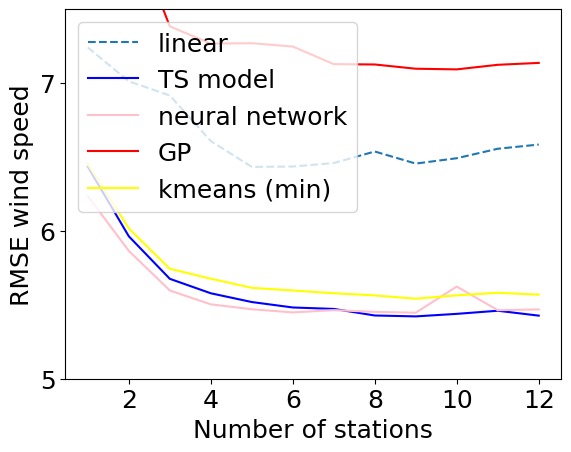

In [7]:
kmeans_train_plot = []
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_test_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in test_results_li_ts_km_nn_full_feature:
     kmeans_train_plot.append(np.min([d['kmeans_test'] for d in exp if 'kmeans_test' in d]))
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
for exp in gpr_test_results[0:12]:
    gpr_test_plot.append(exp['gpr_test'])
     

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, gpr_test_plot, label='GP', c='red')
plt.plot(x_axis, kmeans_train_plot, label='kmeans (min)', c='yellow')
plt.legend(loc="upper left")
plt.ylim(5,7.5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on training data')

for exp in test_results_li_ts_km_nn_full_feature:
    print('exp')
    print('linear')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    
    print('nn')
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")
 
    print('fcm')
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
 
    print('kmeans')
    print(f"{np.round(np.mean([d['kmeans_test'] for d in exp if 'kmeans_test' in d]), 4)}±{np.round(np.std([d['kmeans_test'] for d in exp if 'kmeans_test' in d]),4)}")
 
    print('kmeans min')
    print(f"{np.round(np.min([d['kmeans_test'] for d in exp if 'kmeans_test' in d]), 4)}")
 

In [42]:
kmeans_avg = []
for exp in training_results:
    kmeans_avg.append(np.mean([d['kmeans_train'] for d in exp if 'kmeans_train' in d]))

print(f"{np.mean(kmeans_avg)}±{np.round(np.std(kmeans_avg),4)}")
 

5.713098049163818±0.25920000672340393


In [43]:
kmeans_avg = []
for exp in test_results:
    kmeans_avg.append(np.mean([d['kmeans_test'] for d in exp if 'kmeans_test' in d]))

print(f"{np.mean(kmeans_avg)}±{np.round(np.std(kmeans_avg),4)}")
 

44.71160888671875±32.80799865722656
